#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings

warnings.filterwarnings(action='ignore')

from functools import reduce

from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

from textblob import TextBlob


#### Constants

In [2]:
# column names
COL_COUNTRY = 'country'
COL_GDP = 'GDP'
COL_HDI = 'HDI'
COL_POLARITY = 'polarity'
COL_POPULATION_DENSITY = 'population density'
COL_SUBJECTIVITY = 'subjectivity'
COL_UNEMPLOYMENT = 'unemployment rate'
COL_URBAN_DENSITY = 'urban density (%)'
COL_YEAR = 'year'
COL_NEWS_TEMPLATE = 'news{}'

TARGETS = [
    'Anxiety disorders (%)'
]

FEATURES = [
    COL_GDP,
    COL_HDI,
    COL_POLARITY,
    COL_POPULATION_DENSITY,
    COL_SUBJECTIVITY,
    COL_UNEMPLOYMENT,
    COL_URBAN_DENSITY,
]

SENTIMENT_FEATURES = [
    COL_POLARITY,
    COL_SUBJECTIVITY
]

# directories and filenames
DIR_DATA = 'data'
DIR_FINANCIAL = os.path.join(DIR_DATA, 'financial')
DIR_HDI = os.path.join(DIR_DATA, 'human_development_index')
DIR_MENTAL_HEALTH = os.path.join(DIR_DATA, 'mental_health')
DIR_NEWS = os.path.join(DIR_DATA, 'news')
DIR_POPULATION = os.path.join(DIR_DATA, 'population')

FILENAME_DISORDERS = 'prevalence-by-mental-and-substance-use-disorder.csv'
FILENAME_GDP = 'wrldbnk_gdp.csv'
FILENAME_HDI = 'hdi.csv'
FILENAME_NEWS_HEADLINES = 'news_headlines.csv'
FILENAME_POPULATION_DENSITY = 'wrldbnk_pop_dnst.csv'
FILENAME_UNEMPLOYMENT = 'wrldbnk_unemployment.csv'
FILENAME_URBAN_DENSITY = 'wrldbnk_urban_pop.csv'

# Years
DATE_START = '2005'
DATE_END = '2018'

DATE_RANGE = [str(i) for i in range(2005, 2018)]
DATE_NEWS_FROM = ['{}-02-02', '{}-05-05', '{}-07-07', '{}-11-11']
DATE_NEWS_TO = ['{}-03-03', '{}-06-06','{}-08-08', '{}-12-12']


# country values
SELECTED_COUNTRIES = [
    'south africa',
    'kenya',
    'china',
    'taiwan',
    'japan',
    'south korea',
    'india',
    'pakistan',
    'indonesia',
    'philippines',
    'singapore',
    'thailand',
    'canada',
    'united kingdom',
    'ireland',
    'scotland',
    'australia',
    'new zealand',
    'united states',
]


COUNTRIES_DICT = {
    'australia' : 'australia',
    'canada' : 'canada',
    'china' : 'asia/china',
    'india' : 'asia/india',
    'indonesia' : 'asia/southeast/indonesia',
    'ireland' : 'europe/ireland',
    'japan' : 'asia/japan',
    'kenya' : 'africa/kenya',
    'new zealand' : 'new_zealand',
    'pakistan' : 'asia/pakistan',
    'philippines' : 'asia/philippines',
    'scotland' : 'europe/scotland',
    'singapore' : 'asia/singapore',
    'south africa' : 'africa/south_africa',
    'south korea' : 'asia/south_korea',
    'taiwan' : 'asia/taiwan',
    'thailand' : 'asia/thailand',
    'united kingdom' : 'europe/uk',
    'united states' : 'us'
}


# News URL
URL = 'https://newslookup.com/{}?&ut={}&l=1&utto={}'
FOLDS = 5

## Headline Sentiment Data


In [3]:
# Read in the parsed news headlines from the csv file
file_path = os.path.join(DIR_NEWS, FILENAME_NEWS_HEADLINES)
headlines_df = pd.read_csv(file_path, sep='|', index_col=(0, 1))

average_sentiment_columns = [COL_YEAR, COL_COUNTRY, COL_POLARITY, COL_SUBJECTIVITY]
average_sentiment_df = pd.DataFrame(columns=average_sentiment_columns)

news_columns = [COL_NEWS_TEMPLATE.format(i) for i in range(200)]
news_columns.insert(0, COL_COUNTRY)
news_columns.insert(0, COL_YEAR)
polarity_df = pd.DataFrame(columns=news_columns)
subjectivity_df = pd.DataFrame(columns=news_columns)

# iterate through the headline rows
for index, row in headlines_df.iterrows():
    # lists to store the individual values for each headline
    polarity_list = list()
    subjectivity_list = list()

    polarity_list.extend([index[0], index[1]])
    subjectivity_list.extend([index[0], index[1]])

    # values for the avgerage yearly polarity and subjectivity
    yearly_average_polarity = 0
    yearly_average_subjectivity = 0
    yearly_average_count = 0

    # calculate polarity and subjectivity for each headline
    for entry in row:
        if type(entry) == float:
            polarity_list.append(entry)
            subjectivity_list.append(entry)

        else:
            blob = TextBlob(entry)

            pol_val = 0
            sub_val = 0
            count = 0

            # average the values in case a headline is multiple sentences
            for sentence in blob.sentences:
                pol_val = pol_val + sentence.sentiment.polarity
                sub_val = sub_val + sentence.sentiment.subjectivity
                count = count + 1

            polarity_list.append(pol_val / count)
            subjectivity_list.append(sub_val / count)

            yearly_average_polarity = yearly_average_polarity + pol_val / count
            yearly_average_subjectivity = yearly_average_subjectivity + sub_val / count
            yearly_average_count = yearly_average_count + 1

    yearly_average_polarity = yearly_average_polarity / yearly_average_count
    yearly_average_subjectivity = yearly_average_subjectivity / yearly_average_count

    yearly_average_df = pd.DataFrame([[index[0], index[1], yearly_average_polarity, yearly_average_subjectivity]], columns=average_sentiment_columns)

    pol_row_df = pd.DataFrame([polarity_list], columns=news_columns)
    sub_row_df = pd.DataFrame([subjectivity_list], columns=news_columns)

    average_sentiment_df = pd.concat([average_sentiment_df, yearly_average_df], sort=False)
    polarity_df = pd.concat([polarity_df, pol_row_df], sort=False)
    subjectivity_df = pd.concat([subjectivity_df, sub_row_df], sort=False)

# these are all of the polarities and subjectivity values for each headline
polarity_df = polarity_df.set_index([COL_YEAR, COL_COUNTRY])
subjectivity_df = subjectivity_df.set_index([COL_YEAR, COL_COUNTRY])
average_sentiment_df = average_sentiment_df.set_index([COL_YEAR, COL_COUNTRY])


## Data Loading

In [4]:
def load_data_frame(file_name, path, sep=None):
    """
    Loads data from specified path and name, returns a dataframe
    """
    file_path = os.path.join(path, file_name)
    if not sep:
        return pd.read_csv(file_path)
    return pd.read_csv(file_path, sep=sep)


def load_mental_health_data():
    """
    Loads mental health data, and performs basic preprocessing operations:
        - columns renamed appropriately for compatibility
        - selected countries are filtered
        - unnecessary columns are dropped
    """
    mental_df = load_data_frame(
        FILENAME_DISORDERS,
        DIR_MENTAL_HEALTH
    )

    mental_df.rename(columns={'Entity': COL_COUNTRY, 'Year': COL_YEAR}, inplace=True)
    mental_df.drop(labels='Code', axis=1, inplace=True)
    mental_df[COL_COUNTRY] = mental_df[COL_COUNTRY].str.lower()
    mental_df = mental_df[mental_df[COL_COUNTRY].isin(SELECTED_COUNTRIES)]
    return mental_df


def load_world_bank_data(filename, directory, value):
    """
    Loads World Bank data, and performs basic preprocessing operations:
        - columns renamed appropriately for compatibility
        - selected countries are filtered
        - unnecessary columns are dropped
        - non-numerical values are replaced with NaN or transformed appropriately
    """
    df = load_data_frame(
        filename,
        directory
    )
    df.rename(columns={'Country Name': COL_COUNTRY}, inplace=True)
    df.drop(['Indicator Name', 'Indicator Code', 'Country Code'], axis=1, inplace = True)
    df = df.replace('..', np.NaN)
    df.loc[:,1:] = df.iloc[:, 1:].apply(pd.to_numeric)
    df[COL_COUNTRY] = df[COL_COUNTRY].str.lower()
    df = df.replace('korea, rep.', 'south korea')
    df = df.loc[df[COL_COUNTRY].isin(SELECTED_COUNTRIES)]

    columns = df.columns
    country_index = columns.get_loc(COL_COUNTRY)
    start_index = columns.get_loc(DATE_START)
    end_index = columns.get_loc(DATE_END)
    df = df.iloc[:, np.r_[country_index, start_index:end_index]]

    # Reshape the dataframe to structure `country|year|value`
    df = pd.melt(
        df,
        id_vars=COL_COUNTRY,
        var_name=COL_YEAR,
        value_name=value
    )
    df[COL_YEAR] = df[COL_YEAR].apply(pd.to_numeric)
    df = df.sort_values([COL_COUNTRY, COL_YEAR])
    df.reset_index(inplace=True, drop=True)
    df.dropna(axis=0, inplace=True)
    return df


def load_hdi_data():
    """
    Loads human development index (HDI) data, and performs basic preprocessing operations:
        - columns are renamed for compatibility
        - selected countries are filtered
        - unnecessary columns are dropped
    """
    hdi_df = load_data_frame(
        FILENAME_HDI,
        DIR_HDI
    )

    hdi_df = hdi_df.dropna(how='all', axis=1)
    hdi_df.drop('HDI Rank (2017)', axis=1, inplace=True)
    hdi_df.rename(columns={'Country': COL_COUNTRY, 'Year': COL_YEAR}, inplace=True)
    hdi_df[COL_COUNTRY] = hdi_df[COL_COUNTRY].str.lower().str.strip()
    hdi_df = hdi_df[hdi_df[COL_COUNTRY].isin(SELECTED_COUNTRIES)]
    hdi_df = hdi_df.reset_index(drop=True)
    hdi_df.loc[:,1:] = hdi_df.iloc[:,1:].apply(pd.to_numeric)

    # Reshape the dataframe to structure `country|year|value`
    hdi_df = pd.melt(
        hdi_df,
        id_vars=[COL_COUNTRY],
        var_name=COL_YEAR,
        value_name=COL_HDI
    )

    hdi_df[COL_YEAR] = hdi_df[COL_YEAR].apply(pd.to_numeric)
    hdi_df = hdi_df.drop(hdi_df[hdi_df.year < int(DATE_START)].index)
    hdi_df = hdi_df.drop(hdi_df[hdi_df.year > int(DATE_END)].index)
    return hdi_df



## Joining Datasets

In [5]:
population_df = load_world_bank_data(FILENAME_POPULATION_DENSITY, DIR_POPULATION, COL_POPULATION_DENSITY)
urban_df = load_world_bank_data(FILENAME_URBAN_DENSITY, DIR_POPULATION, COL_URBAN_DENSITY)
gdp_df = load_world_bank_data(FILENAME_GDP, DIR_FINANCIAL, COL_GDP)
unemployment_df = load_world_bank_data(FILENAME_UNEMPLOYMENT, DIR_FINANCIAL, COL_UNEMPLOYMENT)
hdi_df = load_hdi_data()
mental_df = load_mental_health_data()



# Joining individual datasets on population and urban population density, 
# GDP, unemployment, HDI, average news headlines sentiment, and mental health data
data_frames_list = [
    population_df,
    urban_df,
    gdp_df,
    unemployment_df,
    hdi_df,
    average_sentiment_df, 
    mental_df
]

joined_df = reduce(lambda left, right: pd.merge(left, right, on=[COL_COUNTRY, COL_YEAR], how='inner'), data_frames_list)
joined_df.head()

## Pipeline Setup

In [6]:
# Regressors and their tuning parameters
net = MLPRegressor()
net_parameters = {
    'net__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'net__hidden_layer_sizes': [(50), (100), (50, 50), (100, 100), (150, 150), (100, 100, 100)],
    'net__max_iter': [10, 100, 1000]
}

linear = LinearRegression()
linear_parameters = {
    'linear__fit_intercept': [True, False]
}

forest = RandomForestRegressor()
forest_parameters = {
    'forest__n_estimators': [10, 20, 50],
    'forest__max_depth': [2, 5],
    'forest__min_samples_split': [3, 4, 5],
    'forest__max_features': ['auto', 'sqrt', 'log2']
}

svr = SVR(kernel='rbf')
svr_parameters = {
    'svr__C': [0.001, 0.01,  1, 10, 100],
    'svr__epsilon': [ 0.01, .1, 0.5, 1, 2, 4],
}

knn = KNeighborsRegressor()
knn_parameters = {
    'knn__n_neighbors': [5, 10, 20, 30]
}

def generate_pipelined_grid_search(name_estimator, estimator_params, scale=True, pca=False, no_of_features=len(FEATURES)+1):
    """
    Generates a GridSearchCV object by assembling a Pipeline where input estimator is at the end. 
    Default behaviour is to include a 'SelectKBest' step between scaling and regression.
    
    :param name_estimator: a tuple of name and estimator to be used at the end of the pipeline
    :param estimator_params: dictionary of parameters to tune in the estimator
    :param scale: Whether to include a scaling component at the beginning of the pipeline
    :param pca: If true, 'selector' step is associated to a PCA object
    
    :return: A pipeline containing input estimator and a dictionary of parameters to be tuned
             for feature selection.
    """
    steps = []
    if scale or pca:
        steps.append(('scaler', MinMaxScaler()))
    if pca:
        steps.append(('selector', PCA(random_state=0)))
        params = dict(estimator_params, selector__n_components=range(1, no_of_features))

    if not pca: 
        steps.append(('selector', SelectKBest()))
        params = dict(estimator_params, selector__k=range(1, no_of_features))

    steps.append(name_estimator)

    return GridSearchCV(
        Pipeline(steps=steps),
        params,
        cv=FOLDS,
        n_jobs=-1,
        verbose=5
    )

def append_score(model, target_df, grid_searcher, x_test, y_test, pca=False):
    if not pca:
        num_features_used = int(grid_searcher.best_params_['selector__k'])
        scores = grid_searcher.best_estimator_.named_steps.selector.scores_
        highest_scores_indices = np.argpartition(scores, -num_features_used)[-num_features_used:]
        features_used = x_test.columns[highest_scores_indices].values
    else:
        features_used = 'PCA - N/A'

    result_row = pd.DataFrame([{'Model': model, 
                            'Train Score': grid_searcher.best_score_,
                            'Test Score': grid_searcher.best_estimator_.score(x_test, y_test),
                            'Features': features_used
                           }])
    target_df = target_df.append(result_row)
    return target_df.reindex(columns=['Model', 'Train Score', 'Test Score', 'Features'])
    
def print_stats(grid_searcher, x_test, y_test, pca=False):
    print('Best estimator\n', grid_searcher.best_estimator_, '\n')
    print('Best parameters:', grid_searcher.best_params_, '\n')
    print('Train score:', grid_searcher.best_score_)
    print('Test score:', grid_searcher.best_estimator_.score(x_test, y_test))
    
    if not pca:
        num_features_used = int(grid_searcher.best_params_['selector__k'])
        scores = grid_searcher.best_estimator_.named_steps.selector.scores_
        highest_scores_indices = np.argpartition(scores, -num_features_used)[-num_features_used:]
    
        features_used = x_test.columns[highest_scores_indices].values
        print('Features used:', features_used)

<b> Columns in the joined data </b>

In [7]:
joined_df.columns

Index(['country', 'year', 'population density', 'urban density (%)', 'GDP',
       'unemployment rate', 'HDI', 'polarity', 'subjectivity',
       'Schizophrenia (%)', 'Bipolar disorder (%)', 'Eating disorders (%)',
       'Anxiety disorders (%)', 'Drug use disorders (%)', 'Depression (%)',
       'Alcohol use disorders (%)'],
      dtype='object')

<b>Visualizing Polarity</b>
Here we plot polarity vs different disorders for every single country. To see if there might be any relations.

# Defining Modeling Strategy

<b>Based on SelectKBest</b>

In [8]:
def run_select_k_best(x,y,grid_searcher_net,grid_searcher_linear,grid_searcher_forest,grid_searcher_svr,grid_searcher_knn):
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
    print('Columns in Training Data\n', x.columns)

    result_df = pd.DataFrame(columns=['Model', 'Train Score', 'Test Score', 'Features'])

    grid_searcher_net.fit(x_train, y_train)
    print('\t****\tMULTI-LAYER PERCEPTRON\t****')
    print_stats(grid_searcher_net, x_test, y_test)
    result_df = append_score('Multi-Layer Perceptron', result_df, grid_searcher_net, x_test, y_test)

    grid_searcher_linear.fit(x_train, y_train)
    print('\t****\tLINEAR REGRESSOR\t****')
    print_stats(grid_searcher_linear, x_test, y_test)
    result_df = append_score('Linear Regressor', result_df, grid_searcher_linear, x_test, y_test)

    grid_searcher_forest.fit(x_train, y_train)
    print('\t****\tRANDOM FOREST REGRESSOR\t****')
    print_stats(grid_searcher_forest, x_test, y_test)
    result_df = append_score('Random Forest Regressor', result_df, grid_searcher_forest, x_test, y_test)

    grid_searcher_svr.fit(x_train, y_train)
    print('\t****\tSUPPORT VECTOR MACHINE\t****')
    print_stats(grid_searcher_svr, x_test, y_test)
    result_df = append_score('Support Vector Machine', result_df, grid_searcher_svr, x_test, y_test)

    grid_searcher_knn.fit(x_train, y_train)
    print('\t****\tK-NEAREST NEIGHBORS\t****')
    print_stats(grid_searcher_knn, x_test, y_test)
    result_df = append_score('k-Nearest Neighbors', result_df, grid_searcher_knn, x_test, y_test)
    
    return result_df

# Training and Testing
Here we run the CV grid searcher for pipelines and parameters defined earlier. We try to predict each of the illness rates using the gathered features. This script takes a long time to run as it goes through every possible combinations of the provided parameters to find the best model for the job. The results are summed up in the dataframes below.

<h2>With all features</h2>

In [9]:
grid_searcher_net = generate_pipelined_grid_search(('net', net), net_parameters)
grid_searcher_linear = generate_pipelined_grid_search(('linear', linear), linear_parameters)
grid_searcher_forest = generate_pipelined_grid_search(('forest', forest), forest_parameters)
grid_searcher_svr = generate_pipelined_grid_search(('svr', svr), svr_parameters)
grid_searcher_knn = generate_pipelined_grid_search(('knn', knn), knn_parameters)
grid_searcher_net_pca = generate_pipelined_grid_search(('net', net), net_parameters, pca=True)
grid_searcher_linear_pca = generate_pipelined_grid_search(('linear', linear), linear_parameters, pca=True)
grid_searcher_forest_pca = generate_pipelined_grid_search(('forest', forest), forest_parameters, pca=True)
grid_searcher_svr_pca = generate_pipelined_grid_search(('svr', svr), svr_parameters, pca=True)
grid_searcher_knn_pca = generate_pipelined_grid_search(('knn', knn), knn_parameters, pca=True)

# Removing indexing columns (country, year) and rates that will not be predicted
results = []
for TARGET in TARGETS:
    y = joined_df.copy().pop(TARGET)
    x = joined_df.copy()[FEATURES]
    result_skb = run_select_k_best(x,y,grid_searcher_net,grid_searcher_linear,
                      grid_searcher_forest,grid_searcher_svr,grid_searcher_knn)
    result_target = {'target':TARGET,'SelectKBest': result_skb, 'PCA': False}
    results.append(result_target)

Columns in Training Data
 Index(['GDP', 'HDI', 'polarity', 'population density', 'subjectivity',
       'unemployment rate', 'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 671 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1121 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1715 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:  1.6min finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x121b99bf8>)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidd...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (50, 50), 'net__learning_rate': 'constant', 'net__max_iter': 1000, 'selector__k': 4} 

Train score: 0.7767715491575429
Test score: 0.8791614597296945
Features used: ['GDP' 'HDI' 'polarity' 'urban density (%)']
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x121b99bf8>)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__k': 7} 

Train score: 0.7039916938507242
Test score: 0.8623185517949138
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 884 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   30.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x121b99bf8>)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurit...ators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'auto', 'forest__min_samples_split': 3, 'forest__n_estimators': 50, 'selector__k': 7} 

Train score: 0.9527594191970494
Test score: 0.981675695595033
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x121b99bf8>)), ('svr', SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__k': 7, 'svr__C': 10, 'svr__epsilon': 0.1} 

Train score: 0.7357758163059576
Test score: 0.8857402238638656
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 104 out of 140 | elapsed:    0.8s remaining:    0.3s


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x121b99bf8>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__k': 7} 

Train score: 0.6760881468825559
Test score: 0.897100082257263
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.1s finished


# Results - With Sentiment

Results trying to predict Anxiety disorders (%)


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.776772,0.879161,"[GDP, HDI, polarity, urban density (%)]"
0,Linear Regressor,0.703992,0.862319,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Random Forest Regressor,0.952759,0.981676,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Support Vector Machine,0.735776,0.885740,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,k-Nearest Neighbors,0.676088,0.897100,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"


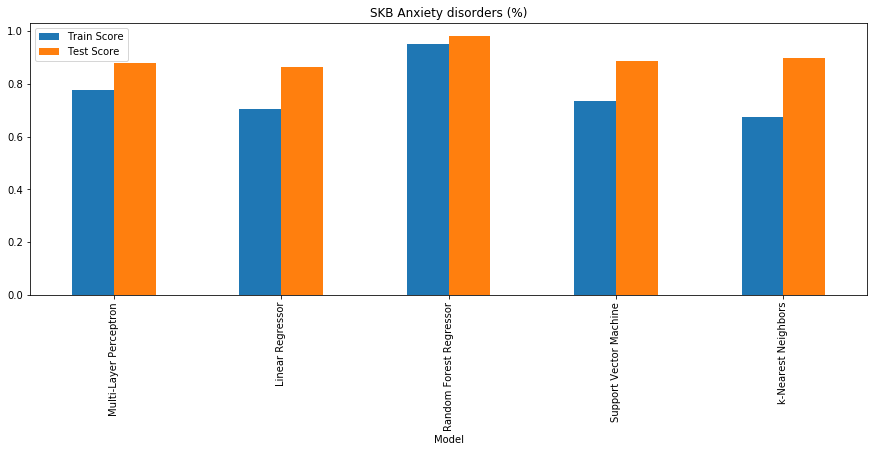

In [12]:
from IPython.display import display, HTML
import copy
pd.set_option('display.max_colwidth', -1)

result_to_iterate = copy.deepcopy(results)
for result in result_to_iterate:
    
    print('\033[1m'+"Results for", result['target'])
    fig, (ax) = plt.subplots(ncols=1, figsize=(15,5))
    
    # Display and draw graph for SelectKBest
    df = result['SelectKBest']
    display(HTML(df.to_html()))  
    ax = df.set_index('Model').plot(kind = 'bar', title='SKB '+result['target'], ax=ax)

# Statistical Analysis of Results
<br>
The data collected above suggests that Random Forest Regressors are the best candidates for estimation of anxiety rates. The hyper-parameters used in the pipelines for the sentiment and no-sentiment groups are used.

### No Sentiment

In [ ]:
TARGET='Anxiety disorders (%)'
y = joined_df.copy().pop(TARGET)
x = joined_df.copy()[FEATURES]
x = x.drop(['polarity','subjectivity'], 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

test_scores_no_sentiment = list()

for i in range(30):
    rfe_no_sentiment = RandomForestRegressor(
        max_depth=5,
        max_features='sqrt',
        min_samples_split=3,
        n_estimators=50
    )

    select_no_sentiment = SelectKBest(k=4)

    scaler_no_sentiment = MinMaxScaler()

    pipeline_no_sentiment = Pipeline(
        steps=[
            ('scaler', scaler_no_sentiment),
            ('selector', select_no_sentiment),
            ('estimator', rfe_no_sentiment),
        ]
    )
    
    pipeline_no_sentiment.fit(x_train, y_train)
    test_scores_no_sentiment.append(pipeline_no_sentiment.score(x_test, y_test))
    
print('\n'.join('{}'.format(score) for score in test_scores_no_sentiment))

### Sentiment

In [ ]:
TARGET='Anxiety disorders (%)'
y = joined_df.copy().pop(TARGET)
x = joined_df.copy()[FEATURES]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

test_scores = list()

for i in range(30):
    rfe = RandomForestRegressor(
        max_depth=5,
        max_features='sqrt',
        min_samples_split=3,
        n_estimators=50
    )

    select = SelectKBest(k=6)

    scaler = MinMaxScaler()

    pipeline = Pipeline(
        steps=[
            ('scaler', scaler),
            ('selector', select),
            ('estimator', rfe),
        ]
    )
    
    pipeline.fit(x_train, y_train)
    test_scores.append(pipeline.score(x_test, y_test))
    
print('\n'.join('{}'.format(score) for score in test_scores))